In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3080
1


In [2]:
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier

In [2]:
# Plot the time-depdendent ROC and calculate AUC
from sksurv.metrics import cumulative_dynamic_auc

In [3]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
#import datetime
#import scipy.stats

%matplotlib inline
#plt.rc('font', family='NanumBarunGothic')
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Noto Sans KR'
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [7]:
train_dummies = pd.read_csv('train_A_dummy.csv')
val_dummies= pd.read_csv('val_A_dummy.csv')
test_dummies= pd.read_csv('test_A_dummy.csv')

In [8]:
X_train = train_dummies.drop(['delta', 'y'], axis=1)
#y_train = train_dummies['delta']

X_val = val_dummies.drop(['delta', 'y'], axis=1)
#y_val = val_dummies['delta']

X_test = test_dummies.drop(['delta', 'y'], axis=1)
#y_test = test_dummies['delta']

In [9]:
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
X_test = X_test.values.astype('float32')

In [10]:
get_target = lambda df: (df['y'].values, df['delta'].values)
y_train = get_target(train_dummies)
y_val = get_target(val_dummies)
durations_test, events_test = get_target(test_dummies)
val = X_val, y_val

In [68]:
in_features = X_train.shape[1]
num_nodes = [1024, 1024]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [69]:
model = CoxPH(net, tt.optim.Adam)

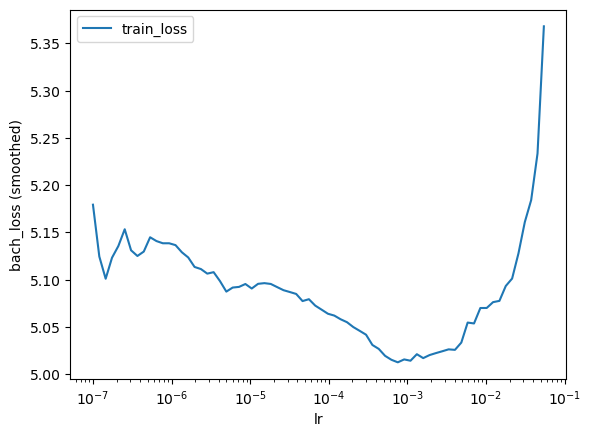

In [70]:
batch_size = 256
lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [71]:
lrfinder.get_best_lr()

0.0001

In [72]:
model.optimizer.set_lr(0.0001)

In [73]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [74]:
%%time
log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[10s / 10s],		train_loss: 4.6823,	val_loss: 4.7419
1:	[10s / 21s],		train_loss: 4.6283,	val_loss: 4.7186
2:	[10s / 31s],		train_loss: 4.6081,	val_loss: 4.7067
3:	[10s / 42s],		train_loss: 4.5939,	val_loss: 4.6944
4:	[11s / 53s],		train_loss: 4.5825,	val_loss: 4.6871
5:	[11s / 1m:5s],		train_loss: 4.5734,	val_loss: 4.6757
6:	[11s / 1m:16s],		train_loss: 4.5627,	val_loss: 4.6713
7:	[11s / 1m:27s],		train_loss: 4.5554,	val_loss: 4.6610
8:	[11s / 1m:38s],		train_loss: 4.5483,	val_loss: 4.6577
9:	[11s / 1m:50s],		train_loss: 4.5416,	val_loss: 4.6542
10:	[11s / 2m:1s],		train_loss: 4.5342,	val_loss: 4.6489
11:	[11s / 2m:13s],		train_loss: 4.5286,	val_loss: 4.6455
12:	[11s / 2m:24s],		train_loss: 4.5240,	val_loss: 4.6401
13:	[11s / 2m:35s],		train_loss: 4.5187,	val_loss: 4.6347
14:	[11s / 2m:47s],		train_loss: 4.5141,	val_loss: 4.6309
15:	[11s / 2m:58s],		train_loss: 4.5090,	val_loss: 4.6297
16:	[11s / 3m:9s],		train_loss: 4.5034,	val_loss: 4.6238
17:	[11s / 3m:21s],		train_loss: 4.4989,	v

140:	[11s / 26m:58s],		train_loss: 4.2300,	val_loss: 4.4828
141:	[11s / 27m:9s],		train_loss: 4.2311,	val_loss: 4.4843
142:	[11s / 27m:20s],		train_loss: 4.2302,	val_loss: 4.4877
143:	[11s / 27m:32s],		train_loss: 4.2274,	val_loss: 4.4870
144:	[11s / 27m:44s],		train_loss: 4.2261,	val_loss: 4.4825
145:	[11s / 27m:55s],		train_loss: 4.2248,	val_loss: 4.4822
146:	[11s / 28m:7s],		train_loss: 4.2247,	val_loss: 4.4809
147:	[11s / 28m:18s],		train_loss: 4.2227,	val_loss: 4.4808
148:	[11s / 28m:30s],		train_loss: 4.2224,	val_loss: 4.4815
149:	[11s / 28m:41s],		train_loss: 4.2202,	val_loss: 4.4838
150:	[12s / 28m:53s],		train_loss: 4.2209,	val_loss: 4.4784
151:	[11s / 29m:5s],		train_loss: 4.2180,	val_loss: 4.4788
152:	[11s / 29m:16s],		train_loss: 4.2205,	val_loss: 4.4787
153:	[11s / 29m:28s],		train_loss: 4.2163,	val_loss: 4.4779
154:	[11s / 29m:39s],		train_loss: 4.2148,	val_loss: 4.4790
155:	[11s / 29m:51s],		train_loss: 4.2155,	val_loss: 4.4786
156:	[11s / 30m:2s],		train_loss: 4.2150,	v

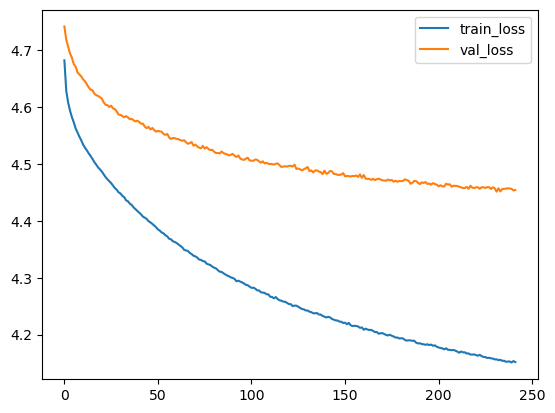

In [75]:
_ = log.plot()

In [76]:
_ = model.compute_baseline_hazards()

In [77]:
surv = model.predict_surv_df(X_test)

In [78]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [79]:
# num_nodes = [1024, 1024]
# batch_size = 256
# dropout = 0.1
# lr = 0.0001
# epoch = 512
ev.concordance_td()

0.7942102198381443

In [4]:
import dill

In [82]:
with open('C:/Users/user/desktop/kopis/ds_gA.pkl', 'wb') as f:
    dill.dump(model, f)

In [5]:
with open('C:/Users/user/desktop/kopis/ds_gA.pkl', 'rb') as f:
    modelA = dill.load(f)

In [11]:
_ = modelA.compute_baseline_hazards()
surv = modelA.predict_surv_df(X_test)

In [85]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

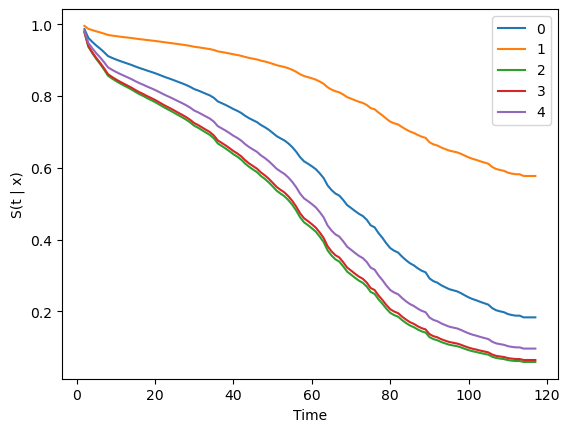

In [86]:
surv.iloc[:, :5].plot()
#surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [87]:
test_dummies['y'].describe()

count    116189.000000
mean         23.748109
std          20.959783
min           2.000000
25%           5.000000
50%          19.000000
75%          37.000000
max         117.000000
Name: y, dtype: float64

In [89]:
y_test = np.array(list(zip(test_dummies['delta'], test_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

In [90]:
y_train = np.array(list(zip(train_dummies['delta'], train_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

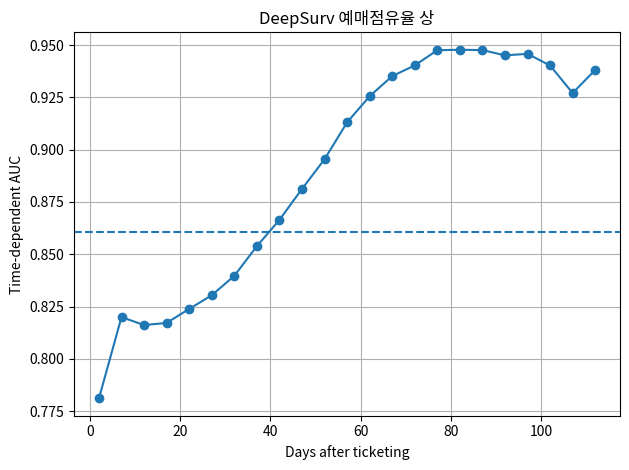

In [93]:
time_interval = np.arange(2, 117, 5)

cph_risk_scores = modelA.predict(X_test).ravel()
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, time_interval)

fig, ax = plt.subplots()

ax.plot(time_interval, cph_auc, marker='o')
ax.axhline(cph_mean_auc, ls='--')
ax.set_xlabel('Days after ticketing')
ax.set_ylabel('Time-dependent AUC')
plt.title('DeepSurv 예매점유율 상')

plt.grid(True)
plt.tight_layout()

In [100]:
cph_auc

array([0.781151  , 0.81999875, 0.81616661, 0.81719489, 0.82388186,
       0.83041139, 0.83969595, 0.85386911, 0.86641668, 0.88121808,
       0.89540393, 0.91304326, 0.92554124, 0.93515598, 0.940271  ,
       0.94754233, 0.94775058, 0.94759658, 0.94508064, 0.94579543,
       0.94024271, 0.92705621, 0.93807252])

In [94]:
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import brier_score

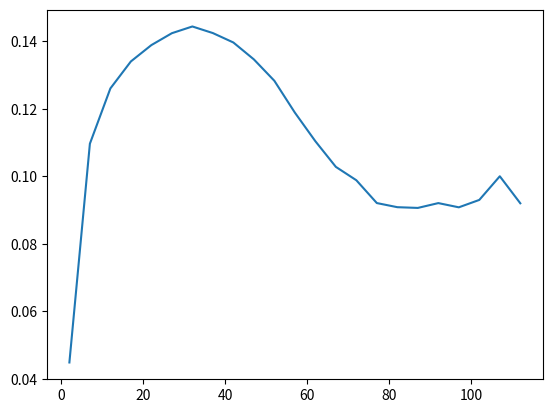

In [95]:
#time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_interval).plot()

In [96]:
ev.brier_score(time_interval)

2      0.044866
7      0.109675
12     0.126048
17     0.134042
22     0.138884
27     0.142405
32     0.144397
37     0.142445
42     0.139656
47     0.134651
52     0.128312
57     0.118888
62     0.110414
67     0.102814
72     0.098848
77     0.092089
82     0.090867
87     0.090650
92     0.092078
97     0.090827
102    0.093020
107    0.100028
112    0.092022
Name: brier_score, dtype: float64

In [97]:
time_interval

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112])

In [99]:
ev.integrated_brier_score(train_dummies.loc[train_dummies['delta']==1, 'y'].drop_duplicates().sort_values().values)

0.11352877963320152

In [12]:
test_df = pd.read_csv('test_A8_n.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117915 entries, 0 to 117914
Data columns (total 34 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   delta     117915 non-null  int64  
 1   y         117915 non-null  int64  
 2   group     117915 non-null  object 
 3   성별        117915 non-null  int64  
 4   단독판매여부    117915 non-null  bool   
 5   예매금액      117915 non-null  int64  
 6   교통개수      117915 non-null  int64  
 7   팔로워합      117915 non-null  int64  
 8   좌석등급개수    117915 non-null  int64  
 9   공연별전사코개수  117915 non-null  int64  
 10  강수        117915 non-null  float64
 11  공연시설인기    117915 non-null  object 
 12  세부장르명     117915 non-null  object 
 13  미세먼지등급    117915 non-null  int64  
 14  공연_요일     117915 non-null  object 
 15  공연_평일주말   117915 non-null  object 
 16  공연_월      117915 non-null  int64  
 17  예매_요일     117915 non-null  object 
 18  예매_평일주말   117915 non-null  object 
 19  예매_월      117915 non-null  int64  
 20  불쾌지수

In [37]:
# 예매
condition_A = (test_df['y']==30) & (test_df['delta']==0) & (test_df['group']=='D') & (test_df['단독판매여부']==True) & (test_df['성별']==1)
ym = test_df[condition_A].drop_duplicates()
ym

,delta,y,group,성별,단독판매여부,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,...,공연횟수,좌석점유율,할인종류개수,결제수단코드,예매방식코드,할인율,일일확진자,예매가능공연개수,공.예,시설합
39911,0,30,D,1,True,49000,14,54964,4,3,...,104,0.318304,7,4,99,0.0,20145,106,30,8
84886,0,30,D,1,True,135000,33,30551,5,3,...,102,0.733573,7,99,1,0.0,5170,93,30,10
97071,0,30,D,1,True,105000,33,30551,5,3,...,102,0.733573,6,2,2,0.0,10827,98,30,10
110142,0,30,D,1,True,104000,33,30551,5,3,...,102,0.733573,8,2,1,0.0,12395,95,30,10
112947,0,30,D,1,True,120000,33,30551,5,3,...,102,0.733573,7,4,4,0.0,12405,95,30,10
114167,0,30,D,1,True,150000,33,30551,5,3,...,102,0.733573,0,99,2,0.0,10494,89,30,10
114168,0,30,D,1,True,150000,33,30551,5,3,...,102,0.733573,0,99,1,0.0,10494,89,30,10
115295,0,30,D,1,True,104000,33,30551,5,3,...,102,0.733573,6,2,2,0.0,15772,88,30,10


In [47]:
# 예매
condition_A = (test_dummies['y']==30) & (test_dummies['delta']==0) & (test_dummies['group_D']==1) & (test_dummies['단독판매여부']==1) & (test_dummies['성별_1']==1)
ym = test_dummies[condition_A].drop_duplicates()
ym

,delta,y,단독판매여부,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,강수,불쾌지수,...,예매_월_10,예매_월_11,예매_월_12,결제수단코드_2,결제수단코드_4,결제수단코드_5,결제수단코드_99,예매방식코드_2,예매방식코드_3,예매방식코드_99
39549,0,30,1,-0.95,-0.67,-0.04,-0.26,-0.42,-0.17,1.18,...,0,0,0,0,1,0,0,0,0,1
84152,0,30,1,0.55,0.94,-0.35,0.60,-0.42,-0.17,-0.74,...,0,0,0,0,0,0,1,0,0,0
95974,0,30,1,0.02,0.94,-0.35,0.60,-0.42,-0.17,-0.06,...,1,0,0,1,0,0,0,1,0,0
108623,0,30,1,0.01,0.94,-0.35,0.60,-0.42,-0.17,-2.29,...,0,1,0,1,0,0,0,0,0,0
112521,0,30,1,0.81,0.94,-0.35,0.60,-0.42,-0.17,-2.02,...,0,1,0,0,0,0,1,1,0,0
112522,0,30,1,0.81,0.94,-0.35,0.60,-0.42,-0.17,-2.02,...,0,1,0,0,0,0,1,0,0,0
113641,0,30,1,0.01,0.94,-0.35,0.60,-0.42,-0.17,-1.83,...,0,1,0,1,0,0,0,1,0,0


In [38]:
# 취소
condition_B = (test_df['y']==30) & (test_df['delta']==1) & (test_df['group']=='B') & (test_df['단독판매여부']==0)& (test_df['성별']==2)
cs = test_df[condition_B].drop_duplicates()
cs

,delta,y,group,성별,단독판매여부,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,...,공연횟수,좌석점유율,할인종류개수,결제수단코드,예매방식코드,할인율,일일확진자,예매가능공연개수,공.예,시설합
3545,1,30,B,2,False,60000,41,195312,5,3,...,101,0.285255,3,2,99,0.0,1771,76,31,4
3677,1,30,B,2,False,130000,41,195312,5,3,...,101,0.285255,2,2,1,0.0,1576,72,37,4
4833,1,30,B,2,False,130000,41,195312,5,3,...,101,0.285255,3,2,2,0.0,1544,71,40,4
7033,1,30,B,2,False,150000,25,191402,4,4,...,53,0.766486,1,4,2,0.0,2338,24,34,12
10350,1,30,B,2,False,100000,25,191402,4,4,...,53,0.766486,1,99,1,0.0,4765,25,40,12
11545,1,30,B,2,False,130000,25,191402,4,4,...,53,0.766486,1,2,2,0.0,4757,25,41,12
23659,1,30,B,2,False,150000,25,191402,4,4,...,53,0.766486,2,4,1,0.0,17186,40,34,12
33085,1,30,B,2,False,100000,41,195312,5,3,...,101,0.285255,4,99,99,0.0,16534,103,33,4
36033,1,30,B,2,False,150000,41,195312,5,3,...,101,0.285255,3,99,2,0.0,24598,104,30,4
36978,1,30,B,2,False,60000,41,195312,5,3,...,101,0.285255,3,2,99,0.0,22993,104,31,4


In [48]:
# 취소
condition_B = (test_dummies['y']==30) & (test_dummies['delta']==1) & (test_dummies['group_B']==1) & (test_dummies['단독판매여부']==0)& (test_dummies['성별_2']==1)
cs = test_dummies[condition_B].drop_duplicates()
cs

,delta,y,단독판매여부,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,강수,불쾌지수,...,예매_월_10,예매_월_11,예매_월_12,결제수단코드_2,결제수단코드_4,결제수단코드_5,결제수단코드_99,예매방식코드_2,예매방식코드_3,예매방식코드_99
3539,1,30,0,-0.76,1.62,1.75,0.60,-0.42,-0.17,0.66,...,0,0,0,1,0,0,0,0,0,1
3671,1,30,0,0.46,1.62,1.75,0.60,-0.42,-0.17,0.49,...,0,0,0,1,0,0,0,0,0,0
4806,1,30,0,0.46,1.62,1.75,0.60,-0.42,-0.17,0.84,...,0,0,0,1,0,0,0,1,0,0
6971,1,30,0,0.81,0.26,1.70,-0.26,1.11,-0.17,0.70,...,0,0,0,0,1,0,0,1,0,0
10260,1,30,0,-0.06,0.26,1.70,-0.26,1.11,-0.17,1.07,...,0,0,0,0,0,0,1,0,0,0
11449,1,30,0,0.46,0.26,1.70,-0.26,1.11,-0.17,1.05,...,0,0,0,1,0,0,0,1,0,0
23436,1,30,0,0.81,0.26,1.70,-0.26,1.11,0.29,0.54,...,0,0,0,0,1,0,0,0,0,0
32774,1,30,0,-0.06,1.62,1.75,0.60,-0.42,-0.17,1.17,...,0,0,0,0,0,0,1,0,0,1
35707,1,30,0,0.81,1.62,1.75,0.60,-0.42,7.93,0.93,...,0,0,0,0,0,0,1,1,0,0
36644,1,30,0,-0.76,1.62,1.75,0.60,-0.42,-0.17,1.01,...,0,0,0,1,0,0,0,0,0,1


In [22]:
ym.index

Int64Index([39549, 84152, 95974, 108623, 112521, 112522, 113641], dtype='int64')

In [45]:
ym.loc[97071]

delta                0
y                   30
group                D
성별                   1
단독판매여부            True
예매금액            105000
교통개수                33
팔로워합             30551
좌석등급개수               5
공연별전사코개수             3
강수                0.00
공연시설인기               C
세부장르명              뮤지컬
미세먼지등급               1
공연_요일         Saturday
공연_평일주말             주말
공연_월                11
예매_요일           Friday
예매_평일주말             평일
예매_월                10
불쾌지수             61.71
소요시간               160
좌석수               1242
매출액         7298542500
공연횟수               102
좌석점유율             0.73
할인종류개수               6
결제수단코드               2
예매방식코드               2
할인율               0.00
일일확진자            10827
예매가능공연개수            98
공.예                 30
시설합                 10
Name: 97071, dtype: object

In [46]:
cs.loc[36978]

delta                1
y                   30
group                B
성별                   2
단독판매여부           False
예매금액             60000
교통개수                41
팔로워합            195312
좌석등급개수               5
공연별전사코개수             3
강수                0.00
공연시설인기               A
세부장르명              뮤지컬
미세먼지등급               0
공연_요일        Wednesday
공연_평일주말             평일
공연_월                 8
예매_요일           Monday
예매_평일주말             평일
예매_월                 7
불쾌지수             78.11
소요시간               180
좌석수               3022
매출액         8849828028
공연횟수               101
좌석점유율             0.29
할인종류개수               3
결제수단코드               2
예매방식코드              99
할인율               0.00
일일확진자            22993
예매가능공연개수           104
공.예                 31
시설합                  4
Name: 36978, dtype: object

In [27]:
surv.iloc[30, ym.index].mean()

0.741286640162177

In [28]:
surv.iloc[30, cs.index].mean()

0.4980993145937668

In [67]:
temp = surv.loc[30, cs.index]
temp

3539    0.37
3671    0.84
4806    0.81
6971    0.07
10260   0.69
11449   0.73
23436   0.26
32774   0.40
35707   0.32
36644   0.37
36646   0.21
37386   0.37
37388   0.30
37391   0.39
37392   0.36
37393   0.53
38371   0.42
38373   0.39
38374   0.45
39172   0.34
39660   0.64
39995   0.38
40845   0.31
48590   0.52
48965   0.75
50523   0.44
50666   0.67
50674   0.53
51007   0.54
51119   0.04
57153   0.28
60218   0.52
61577   0.65
64247   0.86
69998   0.58
70810   0.76
72614   0.70
72632   0.80
78547   0.80
81037   0.84
93898   0.81
Name: 30, dtype: float64

In [68]:
temp[temp<0.6].index

Int64Index([ 3539,  6971, 23436, 32774, 35707, 36644, 36646, 37386, 37388,
            37391, 37392, 37393, 38371, 38373, 38374, 39172, 39995, 40845,
            48590, 50523, 50674, 51007, 51119, 57153, 60218, 69998],
           dtype='int64')

In [62]:
surv.loc[:, cs.index]

,3539,3671,4806,6971,10260,11449,23436,32774,35707,36644,...,60218,61577,64247,69998,70810,72614,72632,78547,81037,93898
duration,,,,,,,,,,,,,,,,,,,,,
2,0.93,0.99,0.99,0.84,0.98,0.98,0.91,0.94,0.93,0.93,...,0.96,0.97,0.99,0.96,0.98,0.98,0.98,0.99,0.99,0.99
3,0.82,0.97,0.96,0.60,0.93,0.94,0.77,0.84,0.80,0.82,...,0.88,0.92,0.97,0.90,0.95,0.93,0.96,0.96,0.97,0.96
4,0.78,0.96,0.95,0.51,0.91,0.92,0.71,0.79,0.75,0.78,...,0.85,0.90,0.96,0.87,0.93,0.92,0.94,0.95,0.96,0.95
5,0.74,0.95,0.94,0.45,0.89,0.91,0.66,0.76,0.71,0.74,...,0.82,0.88,0.95,0.85,0.92,0.90,0.93,0.93,0.95,0.94
6,0.70,0.94,0.93,0.39,0.88,0.90,0.62,0.72,0.67,0.70,...,0.79,0.86,0.95,0.82,0.91,0.88,0.92,0.93,0.94,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.00,0.23,0.17,0.00,0.05,0.07,0.00,0.00,0.00,0.00,...,0.00,0.03,0.27,0.01,0.10,0.05,0.15,0.16,0.24,0.17
114,0.00,0.23,0.17,0.00,0.04,0.07,0.00,0.00,0.00,0.00,...,0.00,0.02,0.27,0.01,0.10,0.05,0.14,0.15,0.23,0.16
115,0.00,0.23,0.17,0.00,0.04,0.07,0.00,0.00,0.00,0.00,...,0.00,0.02,0.27,0.01,0.10,0.05,0.14,0.15,0.23,0.16


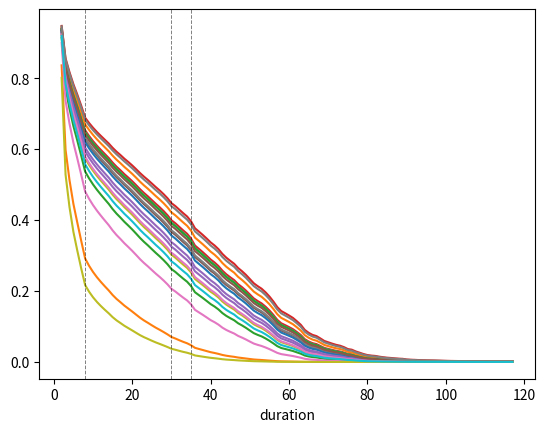

In [85]:
surv.loc[:, (temp[temp<0.5].index)].plot()
plt.axvline(x=8, color='black', linestyle='--', linewidth=0.7, alpha=0.5)
plt.axvline(x=30, color='black', linestyle='--', linewidth=0.7, alpha=0.5)
plt.axvline(x=35, color='black', linestyle='--', linewidth=0.7, alpha=0.5)
plt.legend().set_visible(False)

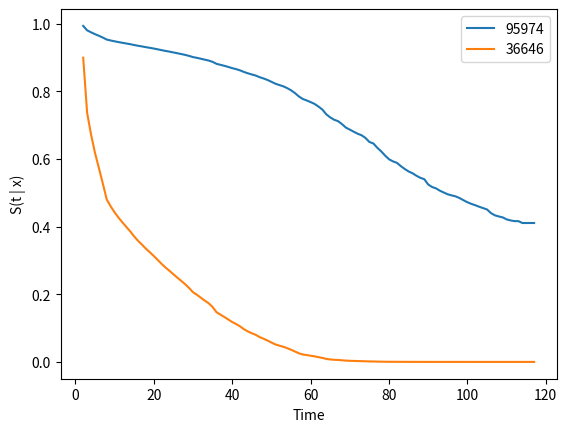

In [35]:
surv.iloc[:, [95974, 36646]].plot()
#surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [167]:
ym.describe()

,delta,y,성별,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,강수,미세먼지등급,...,공연횟수,좌석점유율,할인종류개수,결제수단코드,예매방식코드,할인율,일일확진자,예매가능공연개수,공.예,시설합
count,7.0,7.0,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.0,7.000000
mean,0.0,30.0,1.0,121142.857143,14.714286,13093.285714,5.571429,3.571429,0.0,0.857143,...,96.857143,0.677630,1.714286,29.714286,1.571429,0.0,11528.428571,97.142857,30.0,6.000000
std,0.0,0.0,0.0,31078.816856,17.104719,16330.196403,0.534522,0.534522,0.0,0.377964,...,4.810702,0.052330,2.811541,47.331154,1.133893,0.0,1952.458780,7.128080,0.0,3.741657
min,0.0,30.0,1.0,76500.000000,1.000000,0.000000,5.000000,3.000000,0.0,0.000000,...,93.000000,0.635672,0.000000,2.000000,1.000000,0.0,10157.000000,89.000000,30.0,3.000000
25%,0.0,30.0,1.0,97000.000000,1.000000,0.000000,5.000000,3.000000,0.0,1.000000,...,93.000000,0.635672,0.500000,2.000000,1.000000,0.0,10325.500000,91.500000,30.0,3.000000
50%,0.0,30.0,1.0,127500.000000,1.000000,0.000000,6.000000,4.000000,0.0,1.000000,...,93.000000,0.635672,1.000000,2.000000,1.000000,0.0,10494.000000,95.000000,30.0,3.000000
75%,0.0,30.0,1.0,150000.000000,33.000000,30551.000000,6.000000,4.000000,0.0,1.000000,...,102.000000,0.733573,1.000000,50.500000,1.500000,0.0,11921.000000,104.000000,30.0,10.000000
max,0.0,30.0,1.0,150000.000000,33.000000,30551.000000,6.000000,4.000000,0.0,1.000000,...,102.000000,0.733573,8.000000,99.000000,4.000000,0.0,15555.000000,105.000000,30.0,10.000000


In [168]:
cs.describe()

,delta,y,성별,예매금액,교통개수,팔로워합,좌석등급개수,공연별전사코개수,강수,미세먼지등급,...,공연횟수,좌석점유율,할인종류개수,결제수단코드,예매방식코드,할인율,일일확진자,예매가능공연개수,공.예,시설합
count,41.0,41.0,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,41.000000,41.000000
mean,1.0,30.0,2.0,121451.219512,30.219512,116094.146341,4.414634,2.951220,0.456098,0.243902,...,99.731707,0.469832,2.414634,16.975610,37.243902,0.0,13931.975610,89.439024,34.390244,6.219512
std,0.0,0.0,0.0,28914.703197,11.367744,94967.839551,0.740797,0.589543,2.764783,0.434769,...,16.789914,0.203148,1.341186,34.398029,47.491463,0.0,7701.758161,26.279316,3.270153,2.650587
min,1.0,30.0,2.0,60000.000000,14.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,53.000000,0.285255,0.000000,2.000000,1.000000,0.0,1544.000000,24.000000,30.000000,4.000000
25%,1.0,30.0,2.0,104000.000000,20.000000,0.000000,4.000000,3.000000,0.000000,0.000000,...,101.000000,0.285255,1.000000,2.000000,2.000000,0.0,5617.000000,86.000000,32.000000,4.000000
50%,1.0,30.0,2.0,130000.000000,29.000000,191402.000000,4.000000,3.000000,0.000000,0.000000,...,101.000000,0.405243,3.000000,4.000000,2.000000,0.0,17186.000000,103.000000,33.000000,5.000000
75%,1.0,30.0,2.0,142500.000000,41.000000,195312.000000,5.000000,3.000000,0.000000,0.000000,...,108.000000,0.629109,3.000000,4.000000,99.000000,0.0,20210.000000,104.000000,36.000000,8.000000
max,1.0,30.0,2.0,150000.000000,41.000000,195312.000000,5.000000,4.000000,17.700001,1.000000,...,117.000000,0.768815,6.000000,99.000000,99.000000,0.0,24598.000000,114.000000,41.000000,12.000000


In [39]:
pd.options.display.float_format = '{:.2f}'.format
pd.concat([pd.DataFrame(ym.median()), pd.DataFrame(cs.median())], axis=1)

,0,0
delta,0.00,1.00
y,30.00,30.00
성별,1.00,2.00
단독판매여부,1.00,0.00
예매금액,112500.00,130000.00
교통개수,33.00,29.00
팔로워합,30551.00,191402.00
좌석등급개수,5.00,4.00
공연별전사코개수,3.00,3.00
강수,0.00,0.00
